In [12]:
# this notebook contains the whole pipeline of the proposed model

# Library header
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras import Model, Input
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2
import numpy as np


# import own libraries
from HandSeg.handseg_two_classes import *
from HandSeg.util import *

In [2]:
# initialize the handseg model and load weights
# returns the model object
def initializeHandSeg():
    inputs = Input(shape=(480, 640, 3))
    handseg = Model(inputs=inputs, outputs=handseg_model(inputs), name="HandSeg_Model")

    # build the segmentation model
    handseg.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    # load the weights from previous training
    handseg.load_weights("./HandSeg/weights/handseg_model_twoClasses_4.h5")
    return handseg

In [3]:
# this function will process the whole pipeline of the model
def classifySign(img):
    # ============================= Step 1 =============================
    # load the hand segmentation model
    segmentation_model = initializeHandSeg()
    #reshape input image
    input_image = cv2.resize(img, (640, 480))
    input_image = np.reshape(input_image, (1,480, 640, 3))
    # apply preprocessing
    input_image = preprocess2(input_image)
    # predict hand segmentation
    output_image = segmentation_model.predict(input_image)
    # interpret prediction
    output_image = interpretPrediction(output_image[0])
    # ============================= Step 2 =============================
    # draw the bounding box
    box = drawBoxes(output_image, input_image[0])
    # ============================= Step 3 =============================
    return box

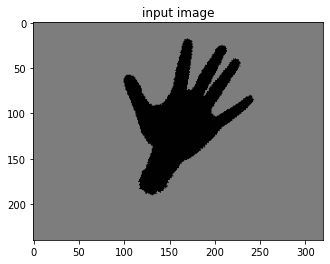

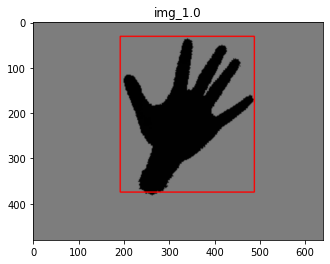

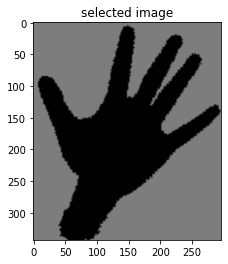

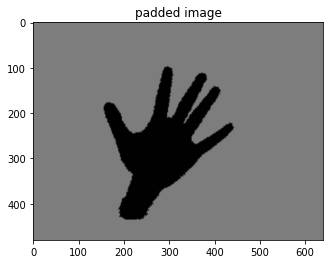

(240, 320, 3)


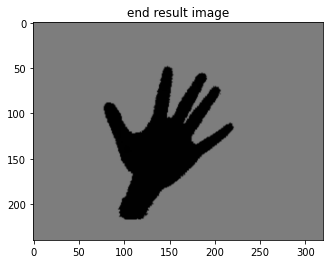

True

In [10]:
img = cv2.imread("./image_0002.png")
#img = cv2.imread("./HandSeg/test_depth.png")
plt.imshow(img); plt.title('input image'); plt.show()

x, y, width, height = classifySign(img)
box_image = cv2.resize(img, (640, 480))
box_image = box_image[y:(y+height), x:(x+width)]
plt.imshow(box_image, cmap="Greys"); plt.title('selected image'); plt.show()

# create new image of desired size and color (blue) for padding
new_width = 640
new_height = 480
color_val = box_image.max()
color = (color_val,color_val,color_val)
result = np.full((new_height,new_width,3), color, dtype=np.uint8)


# compute center offset
x_start = (new_width - box_image.shape[0]) // 2
y_start = (new_height - box_image.shape[1]) // 2

# copy img image into center of result image
result[y_start:y_start+box_image.shape[0], x_start:x_start+ box_image.shape[1]] = box_image

# view result
plt.imshow(result); plt.title('padded image'); plt.show()


result = cv2.resize(result, (320, 240))
print(result.shape)
plt.imshow(result); plt.title('end result image'); plt.show()
cv2.imwrite("./PixelwiseRegression/Data/ICVL/image_0000.png",result)